In [1]:
import zuko
from zuko.bayesian import BayesianModel
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# ------------------
data_path = "/eos/user/d/dvalsecc/uncertainties_flows_paper/500k_2d_gaussian_heavy_tail_target_set.npy"
target_data = np.load(data_path) #load data from generate_target_data.py 
target_tensor = torch.from_numpy(target_data)

In [3]:
target_tensor[:, 0] = (target_tensor[:, 0 ] +0.5) *6
target_tensor[:, 1] = target_tensor[:, 1 ] *2.5 - 5


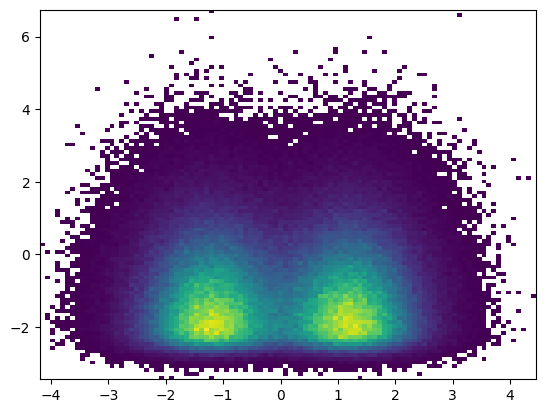

In [170]:
plt.hist2d(target_tensor[:,0], target_tensor[:,1], bins=100, cmin=1);

In [4]:
from torch.utils.data import DataLoader, TensorDataset, random_split
dataset =  TensorDataset(target_tensor.to("cuda"))
train_ds , val_ds = random_split(dataset, [0.9,0.1])
train_loader = DataLoader(
        train_ds,
        batch_size=512,
        shuffle=True,
        pin_memory=False,
    )
val_loader = DataLoader(
        val_ds,
        batch_size=4096,
        shuffle=True,
        pin_memory=False,
    )

In [5]:
def train_flow(model,  train_data, val_data, optimizer,  scheduler, batch_size, epochs, steps=1000,  niter_plot = None, niter_print=500):
    val_losses = []
    
    N_train_events = len(train_data.dataset)

    for epoch in range(epochs):
        model.current_epoch = epoch
        model.train()
        train_loss = 0.
        
        for batch_idx, X in enumerate(train_data):
            optimizer.zero_grad()
            
            with model.reparameterize(local_trick=True) as bmodel:
                log_prob = bmodel().log_prob(X[0])
            
            kl = model.kl_divergence()/N_train_events
            loss = - log_prob.mean() +  kl
        
            train_loss += loss.item()    
            
            if batch_idx % niter_print == 0:
                print(f"epoch {epoch}, step {batch_idx}/{steps}, Loss: {loss.item():.4f}, KL loss: {kl.item():.4f}")
                 
            loss.backward() 
            optimizer.step()
            scheduler.step()
            if niter_plot:
                if batch_idx == niter_plot:
                    break

        train_loss /= (batch_idx+1)
        
    
        val_loss = 0.  
        with torch.no_grad():
            for X in val_data:
                bmodel = model.sample_model()
                log_probval = bmodel().log_prob(X[0])
                val_loss = -log_probval.mean()
            
            print(f"epoch {epoch}, Validation Loss: {val_loss:.4f}")

        with torch.no_grad():
            bmodel = bayes_model.sample_model()
            y = bmodel().rsample((len(target_data),))
            
        fig = plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.hist(y.cpu()[:,0], bins=100, range=(-5,5));
        plt.hist(target_data[:,0], bins=100, range=(-5,5),histtype="step", linewidth=2);

        plt.subplot(1,2,2)
        plt.hist(y.cpu()[:,1], bins=100, range=(-5,5));
        plt.hist(target_data[:,1], bins=100, range=(-5,5),histtype="step", linewidth=2);
        plt.show()


        #scheduler.step(val_loss)
        val_losses.append(val_loss)
        #exp.log_metric("loss_val", val_loss, epoch=epoch)
            
        print(f"End of epoch {epoch}")
    return model, val_losses



In [6]:
from torch.optim.lr_scheduler import _LRScheduler, LambdaLR
import math
# Define the warmup + cosine decay function
def LinearWarmupCosineDecay(optimizer, warmup_steps, total_steps):
    def lr_lambda(current_step):
        # If before or within warmup, do linear warmup (inclusive of step==warmup_steps -> 1.0)
        if current_step <= warmup_steps:
            # Linear warmup from 0 -> 1 over warmup_steps
            return float(current_step) / float(max(1, warmup_steps))

        # After warmup, for steps up to total_steps use cosine decay from 1 -> 0.
        # For any step >= total_steps we must not let the lr go back up: clamp to 0.0
        if current_step >= total_steps:
            return 1e-8

        # Cosine decay in (warmup_steps, total_steps)
        progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        # cosine goes from 1 -> 0 as progress goes 0 -> 1
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return LambdaLR(optimizer, lr_lambda)

epoch 0, step 0/878, Loss: 4.2899, KL loss: 0.2538
epoch 0, step 200/878, Loss: 4.0419, KL loss: 0.2537
epoch 0, step 400/878, Loss: 3.4293, KL loss: 0.2536
epoch 0, step 600/878, Loss: 3.3866, KL loss: 0.2533
epoch 0, step 800/878, Loss: 3.3908, KL loss: 0.2530
epoch 0, Validation Loss: 3.1828


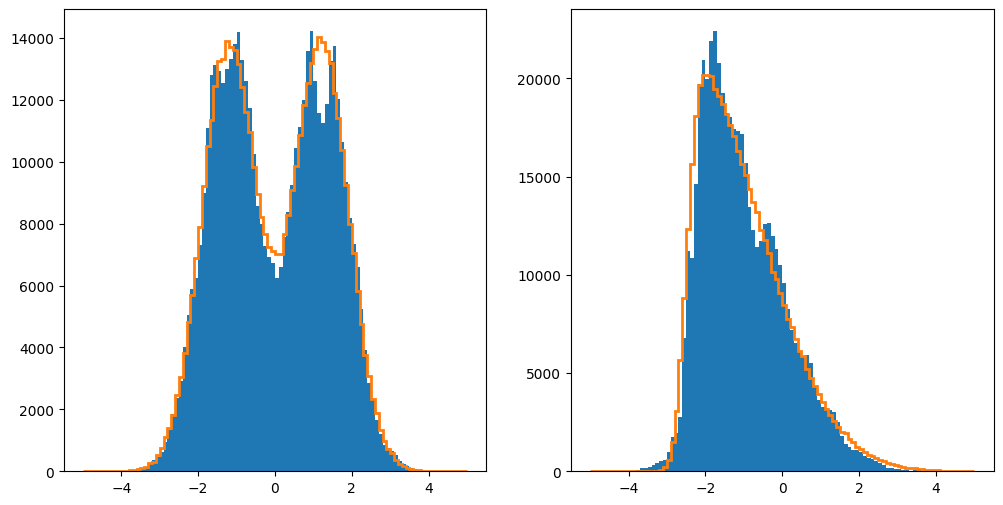

End of epoch 0
epoch 1, step 0/878, Loss: 3.3981, KL loss: 0.2528
epoch 1, step 200/878, Loss: 3.3362, KL loss: 0.2524
epoch 1, step 400/878, Loss: 3.3438, KL loss: 0.2520
epoch 1, step 600/878, Loss: 3.3604, KL loss: 0.2516
epoch 1, step 800/878, Loss: 3.3994, KL loss: 0.2512
epoch 1, Validation Loss: 3.1645


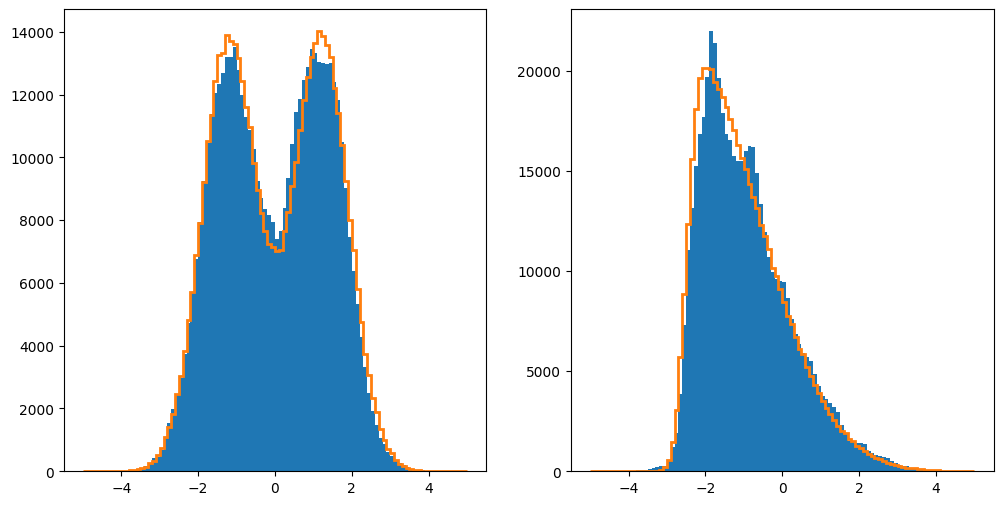

End of epoch 1
epoch 2, step 0/878, Loss: 3.3867, KL loss: 0.2510
epoch 2, step 200/878, Loss: 3.3779, KL loss: 0.2506
epoch 2, step 400/878, Loss: 3.3381, KL loss: 0.2502
epoch 2, step 600/878, Loss: 3.3451, KL loss: 0.2498
epoch 2, step 800/878, Loss: 3.3505, KL loss: 0.2494
epoch 2, Validation Loss: 3.0628


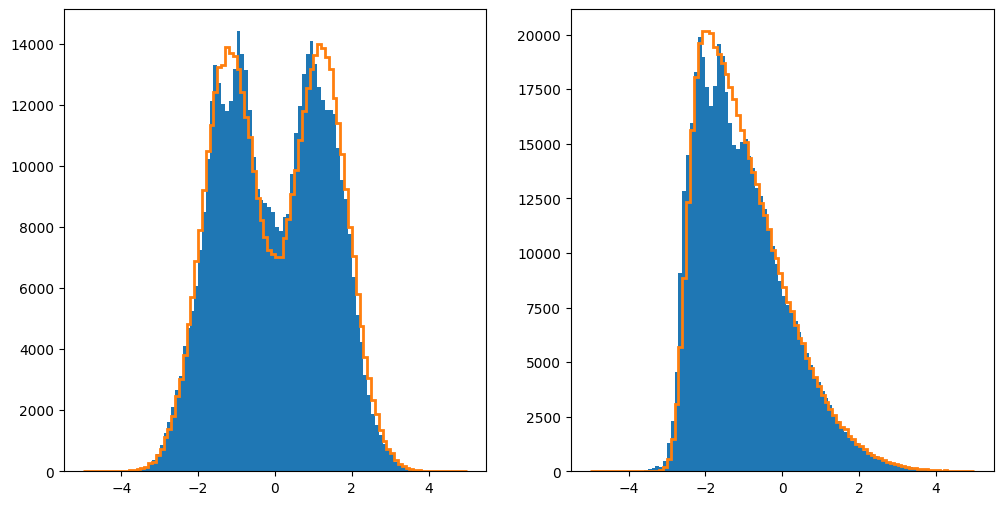

End of epoch 2
epoch 3, step 0/878, Loss: 3.4569, KL loss: 0.2493
epoch 3, step 200/878, Loss: 3.3692, KL loss: 0.2488
epoch 3, step 400/878, Loss: 3.3255, KL loss: 0.2484
epoch 3, step 600/878, Loss: 3.3717, KL loss: 0.2480
epoch 3, step 800/878, Loss: 3.3469, KL loss: 0.2476
epoch 3, Validation Loss: 3.0952


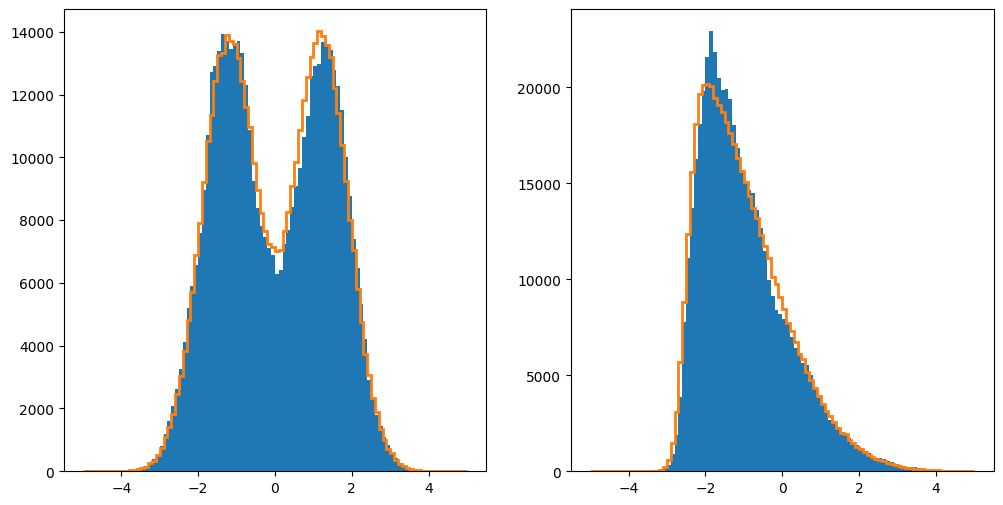

End of epoch 3
epoch 4, step 0/878, Loss: 3.4043, KL loss: 0.2474
epoch 4, step 200/878, Loss: 3.4166, KL loss: 0.2470
epoch 4, step 400/878, Loss: 3.3924, KL loss: 0.2466
epoch 4, step 600/878, Loss: 3.3900, KL loss: 0.2462
epoch 4, step 800/878, Loss: 3.4144, KL loss: 0.2457
epoch 4, Validation Loss: 3.1785


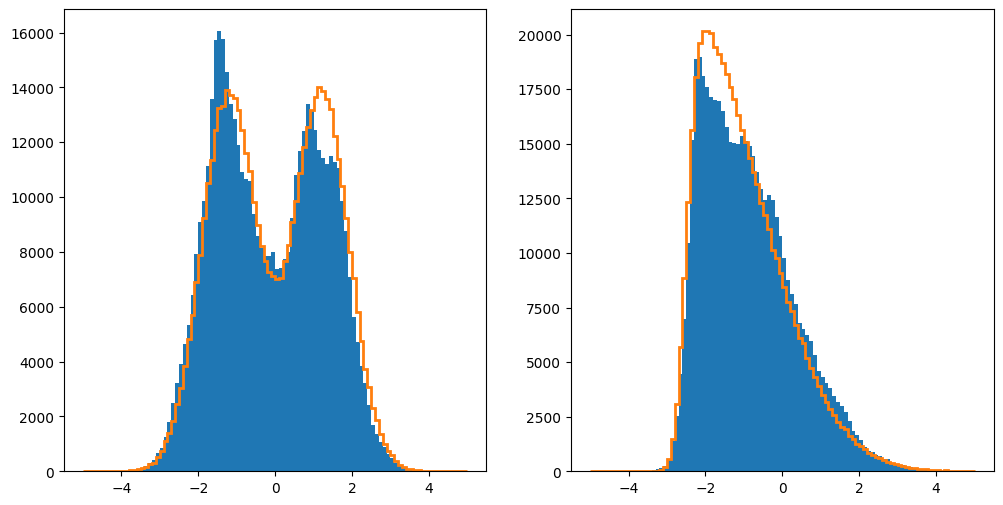

End of epoch 4
epoch 5, step 0/878, Loss: 3.3936, KL loss: 0.2456
epoch 5, step 200/878, Loss: 3.3382, KL loss: 0.2451
epoch 5, step 400/878, Loss: 3.3282, KL loss: 0.2447
epoch 5, step 600/878, Loss: 3.3294, KL loss: 0.2443
epoch 5, step 800/878, Loss: 3.3469, KL loss: 0.2439
epoch 5, Validation Loss: 3.1389


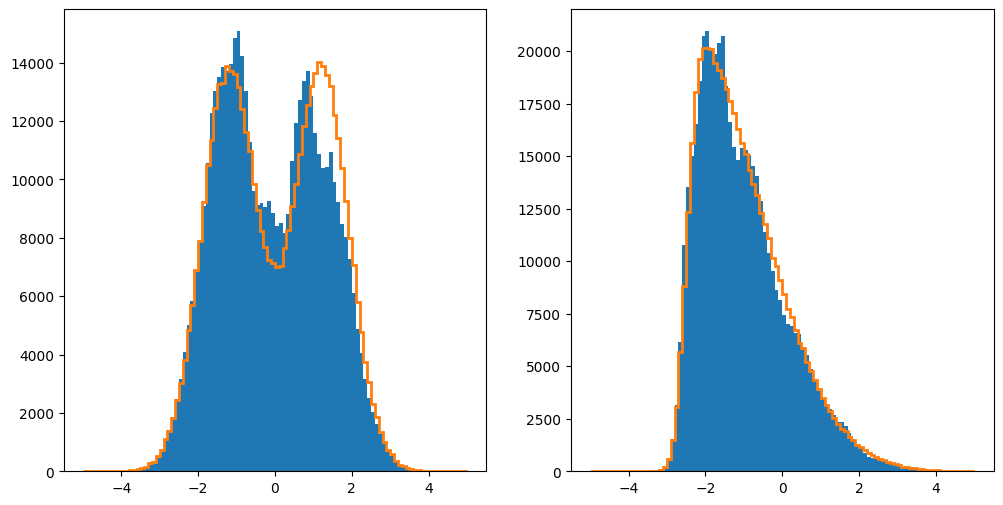

End of epoch 5
epoch 6, step 0/878, Loss: 3.3510, KL loss: 0.2437
epoch 6, step 200/878, Loss: 3.3745, KL loss: 0.2433
epoch 6, step 400/878, Loss: 3.2694, KL loss: 0.2428
epoch 6, step 600/878, Loss: 3.3121, KL loss: 0.2424
epoch 6, step 800/878, Loss: 3.3349, KL loss: 0.2420
epoch 6, Validation Loss: 3.1643


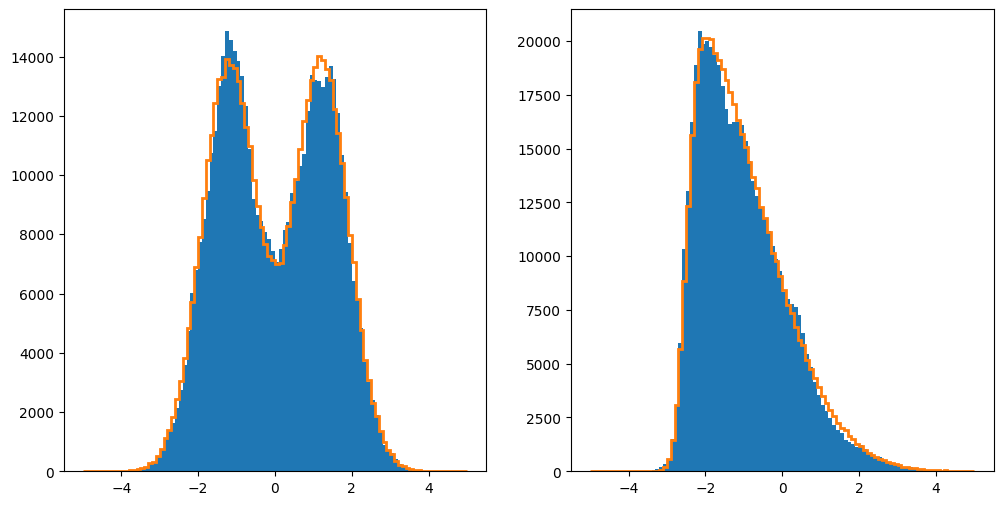

End of epoch 6
epoch 7, step 0/878, Loss: 3.3472, KL loss: 0.2418
epoch 7, step 200/878, Loss: 3.3181, KL loss: 0.2414
epoch 7, step 400/878, Loss: 3.3229, KL loss: 0.2410
epoch 7, step 600/878, Loss: 3.3414, KL loss: 0.2405
epoch 7, step 800/878, Loss: 3.3029, KL loss: 0.2401
epoch 7, Validation Loss: 3.1582


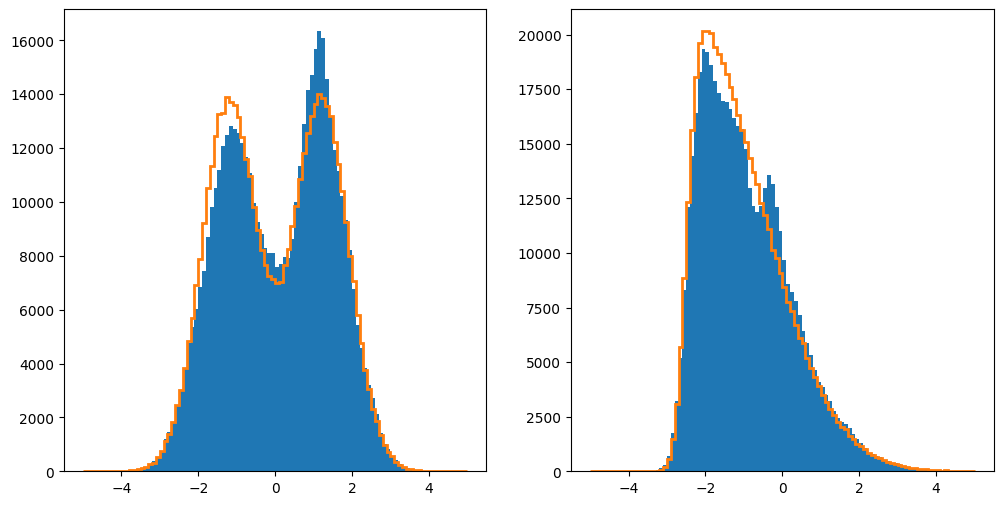

End of epoch 7
epoch 8, step 0/878, Loss: 3.3124, KL loss: 0.2399
epoch 8, step 200/878, Loss: 3.3236, KL loss: 0.2395
epoch 8, step 400/878, Loss: 3.3352, KL loss: 0.2391
epoch 8, step 600/878, Loss: 3.3912, KL loss: 0.2386
epoch 8, step 800/878, Loss: 3.4015, KL loss: 0.2382
epoch 8, Validation Loss: 3.1175


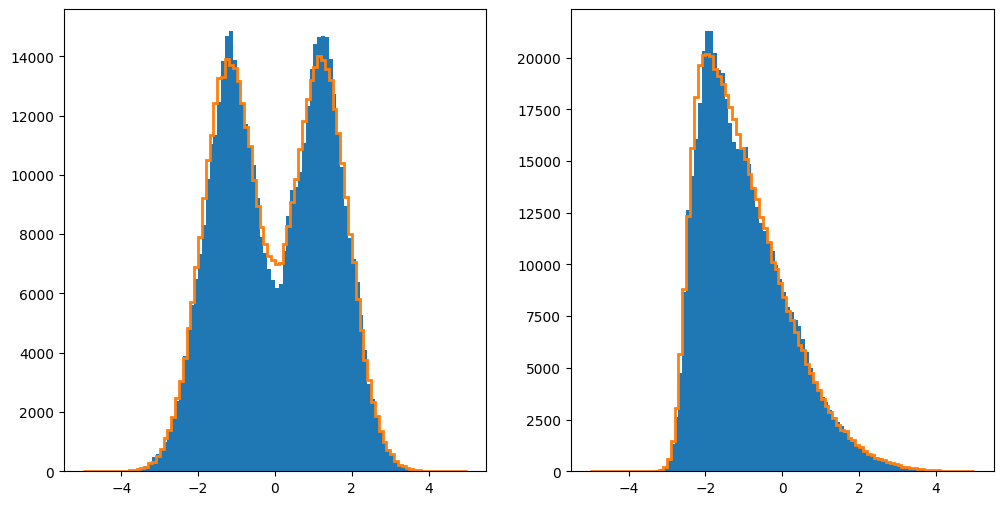

End of epoch 8
epoch 9, step 0/878, Loss: 3.3802, KL loss: 0.2380


In [177]:
model = zuko.flows.NSF(features=2, context=0,  bins= 20,
                                            transforms=2, hidden_features=(64,64,64)).to("cuda")
bayes_model = BayesianModel(model, init_logvar=-9.)

optimizer = torch.optim.AdamW(bayes_model.parameters(), lr = 1e-4)

nepochs = 50
steps_per_epoch = len(train_ds) // 512
total_steps = nepochs * steps_per_epoch
warmup_steps = steps_per_epoch
scheduler = LinearWarmupCosineDecay(optimizer, warmup_steps, total_steps)

flow, val_losses = train_flow(bayes_model,  train_loader, val_loader,  optimizer, scheduler,  batch_size = 512,
                             epochs=nepochs,   
                             steps=steps_per_epoch,   niter_print=200)

# Save the model
#torch.save(model.state_dict(), config[model]['model']['name'])


In [78]:
torch.save(bayes_model.state_dict(), "bayes_model_v2.pt")

In [7]:
model = zuko.flows.NSF(features=2, context=0,  bins= 20,
                                            transforms=2, hidden_features=(64,64,64)).to("cuda")
bayes_model = BayesianModel(model, init_logvar=-9.)
bayes_model.load_state_dict(torch.load("bayes_model_v2.pt"))

<All keys matched successfully>

In [8]:
ys = []
for i in range(30):
    with torch.no_grad():
            bmodel = bayes_model.sample_model()
            y = bmodel().rsample((len(target_data),))
            ys.append(y.unsqueeze(0))
        

In [9]:
Ys = torch.cat(ys, dim=0)

In [10]:

def bayesian_histogram(data, bins, density=False, mask = None):
    if mask is None:
        if isinstance(data, list):
            histograms = np.stack([np.histogram(d, bins=bins, density=density)[0] for d in data], axis=0)
        else:
            histograms = np.stack([np.histogram(data[i,:], bins=bins, density=density)[0] for i in range(data.shape[0])], axis=0)
    else:
        if isinstance(data, list):
            histograms = np.stack([np.histogram(d[mask[i]], bins=bins, density=density)[0] for i, d in enumerate(data)], axis=0)
        else:
            histograms = np.stack([np.histogram(data[i,:][mask[i]], bins=bins, density=density)[0] for i in range(data.shape[0])], axis=0)
    return np.mean(histograms, axis=0), np.std(histograms, axis=0)


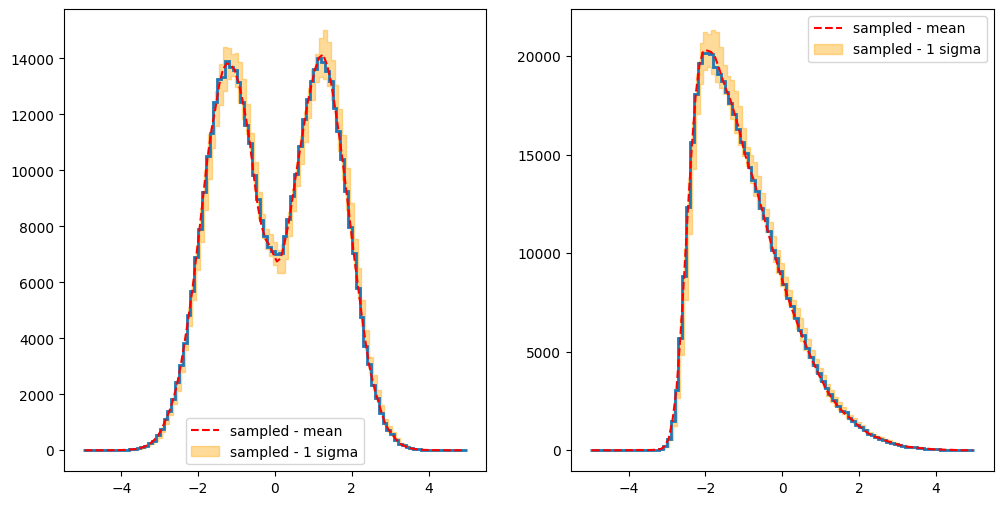

In [12]:

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

N, bins, _ = plt.hist(target_data[:,0], bins=100, range=(-5,5),histtype="step", linewidth=2);

mean, stds = bayesian_histogram(Ys[:,:,0].cpu(), bins)
bins_centers  = (bins[:-1]+bins[1:])/2

plt.plot(bins_centers, mean, alpha=1, linestyle="--", color="red", label="sampled - mean")
plt.fill_between(bins_centers, mean - stds, mean + stds, alpha=0.4, step="post",
                    color="orange", label="sampled - 1 sigma")
# plt.fill_between(bins_centers, mean - 2*stds, mean + 2*stds, alpha=0.2, step="post",
#                     color="orange", label="sampled - 2 sigmas")

plt.legend()

plt.subplot(1,2,2)

N, bins, _ = plt.hist(target_data[:,1], bins=100, range=(-5,5),histtype="step", linewidth=2);

mean, stds = bayesian_histogram(Ys[:,:,1].cpu(), bins)
bins_centers  = (bins[:-1]+bins[1:])/2

plt.plot(bins_centers, mean, alpha=1, linestyle="--", color="red", label="sampled - mean")
plt.fill_between(bins_centers, mean - stds, mean + stds, alpha=0.4, step="post",
                    color="orange", label="sampled - 1 sigma")
# plt.fill_between(bins_centers, mean - 2*stds, mean + 2*stds, alpha=0.2, step="post",
#                     color="orange", label="sampled - 2 sigmas")

plt.legend()
plt.show()

(array([5.0000e+00, 1.0000e+01, 1.8000e+01, 1.4000e+01, 3.5000e+01,
        5.1000e+01, 8.6000e+01, 1.3300e+02, 1.1900e+02, 1.1400e+02,
        1.5200e+02, 2.1600e+02, 2.4000e+02, 2.6400e+02, 3.2200e+02,
        3.0400e+02, 2.6000e+02, 3.1700e+02, 3.3300e+02, 3.3800e+02,
        3.0700e+02, 2.9400e+02, 2.8000e+02, 3.2400e+02, 3.1700e+02,
        2.9500e+02, 3.0200e+02, 2.4300e+02, 3.1200e+02, 3.1000e+02,
        3.2300e+02, 3.4600e+02, 2.8900e+02, 3.1100e+02, 2.9000e+02,
        3.3500e+02, 3.3100e+02, 3.0500e+02, 3.4800e+02, 3.9300e+02,
        3.8200e+02, 4.6800e+02, 5.0500e+02, 5.0700e+02, 5.6400e+02,
        6.7500e+02, 7.7300e+02, 9.4100e+02, 1.5610e+03, 1.6402e+04]),
 array([-9.41108036, -9.35560226, -9.30012417, -9.24464607, -9.18916798,
        -9.13368988, -9.07821178, -9.02273369, -8.96725559, -8.9117775 ,
        -8.8562994 , -8.8008213 , -8.74534321, -8.68986511, -8.63438702,
        -8.57890892, -8.52343178, -8.46795273, -8.41247559, -8.35699749,
        -8.30151939, -8.24

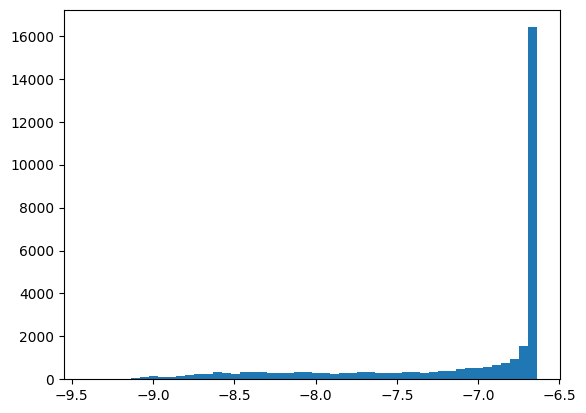

In [14]:
plt.hist(torch.cat([ p.flatten() for p  in  bayes_model.logvars.values()]).cpu().detach().numpy(), bins=50)

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], shape=(100, 100)),
 array([-4.955995  , -4.8586445 , -4.761294  , -4.6639433 , -4.5665927 ,
        -4.469242  , -4.3718915 , -4.274541  , -4.177191  , -4.0798397 ,
        -3.9824893 , -3.885139  , -3.7877884 , -3.6904378 , -3.5930872 ,
        -3.4957366 , -3.398386  , -3.3010354 , -3.2036848 , -3.1063342 ,
        -3.0089836 , -2.9116333 , -2.8142827 , -2.716932  , -2.6195815 ,
        -2.5222309 , -2.4248803 , -2.3275297 , -2.2301793 , -2.1328287 ,
        -2.035478  , -1.9381275 , -1.8407769 , -1.7434263 , -1.6460757 ,
        -1.5487251 , -1.4513745 , -1.3540242 , -1.2566736 , -1.159323  ,
        -1.0619724 , -0.9646218 , -0.8672714 , -0.7699208 , -0.6725702 ,
        -0.57521963, -0.47786903, -0.380

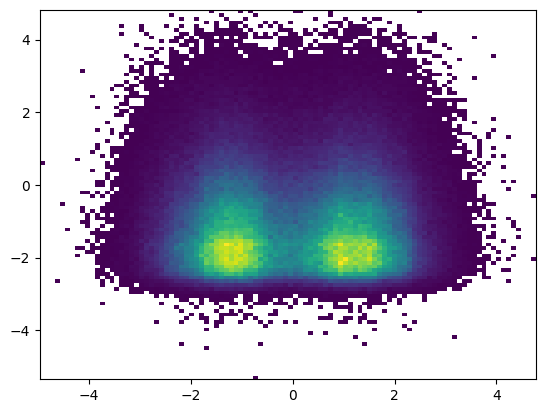

In [15]:
plt.hist2d(Ys[0][:,0].cpu(), Ys[0][:,1].cpu(), bins=100, cmin=1)